# timeseries query

A Query defines a multivariate time series query on the Waylay timeseries database, and can be stored under a name as a Query Configuration.

These Query Configurations can be authored and tested on the console https://console.waylay.io/queries and be saved under a name. 

The `queries.query` resource in the Waylay Python SDK uses the queries backend REST services to read, create, update, delete and execute Query Configuration using a standardised JSON representation. 

A JSON definition of Query can also be executed without storing in a Configuration.

See https://docs.waylay.io/api/query/ or https://docs-io.waylay.io/#/features/query/ for more documentation.

## example usage
Import the client and check your backend connections

In [1]:
from waylay import WaylayClient
from waylay.exceptions import RestResponseError
waylay_client = WaylayClient.from_profile('demo')

In [2]:
waylay_client.queries.about.version()

'v0.2.2'

This notebook assumes you have uploaded the example data at [../data/weather_data.csv](../data/weather_data.csv)

In [3]:
weather_resource_id = 'weather_data'
try:
    waylay_client.resources.resource.get(weather_resource_id)
    display(f'{weather_resource_id} exists')
except RestResponseError as exc:
    if (exc.response.status_code == 404):
        etl_tool=waylay_client.timeseries.etl_tool
        import_job = etl_tool.prepare_import('../data/weather_data.csv', resource=weather_resource_id)
        etl_tool.initiate_import(import_job)
        display(f'{weather_resource_id} uploaded')
    else:
        display(exc)
        

1.00csv_files [00:00, 57.0csv_files/s]
  0%|             | 4.00/1196.0Y [00:00<00:04, 259rows/s]


'weather_data uploaded'

In [5]:
# check the series exist
series = waylay_client.data.series.list(weather_resource_id)
series

[{'name': 'dew_point', 'latest': {'timestamp': 1641621060000, 'value': 122}},
 {'name': 'sea_level_pressure',
  'latest': {'timestamp': 1641621060000, 'value': 10236}},
 {'name': 'temperature', 'latest': {'timestamp': 1641621060000, 'value': 28}},
 {'name': 'visibility',
  'latest': {'timestamp': 1641621060000, 'value': 16093}}]

We create a query definition and check wether a query with that name already exists.
We update or create the query accordingly

In [6]:
query_name = f'all_{weather_resource_id}'

query_definition = {
    'resource': weather_resource_id,
    'until': series[0]['latest']['timestamp'],
    'freq': 'PT1H',
    
    'data' : [ 
        {
            'metric': s['name'],
            'aggregation': aggr
        }
        for s in series
        for aggr in ['count', 'max','mean']
    ]
}
query_entity = {
    'name': query_name,
    'meta' : { 'description': 'an example query on weather data'},
    'query': query_definition
}

try:
    waylay_client.queries.query.get(query_name)
    display(f'query {query_name} exists')
    waylay_client.queries.query.replace(query_name, body=query_entity)
    display(f'query {query_name} replaced')
except RestResponseError as exc:
    if (exc.response.status_code == 404):
        waylay_client.queries.query.create(body=query_entity)
        display(f'query {query_name} created')
    else:
        display(exc)



'query all_weather_data created'

`waylay_client.queries.query.get` fetches the query _definition_.

In [7]:
waylay_client.queries.query.get(query_name)

{'until': 1641621060000,
 'freq': 'PT1H',
 'data': [{'metric': 'dew_point', 'aggregation': 'count'},
  {'metric': 'dew_point', 'aggregation': 'max'},
  {'metric': 'dew_point', 'aggregation': 'mean'},
  {'metric': 'sea_level_pressure', 'aggregation': 'count'},
  {'metric': 'sea_level_pressure', 'aggregation': 'max'},
  {'metric': 'sea_level_pressure', 'aggregation': 'mean'},
  {'metric': 'temperature', 'aggregation': 'count'},
  {'metric': 'temperature', 'aggregation': 'max'},
  {'metric': 'temperature', 'aggregation': 'mean'},
  {'metric': 'visibility', 'aggregation': 'count'},
  {'metric': 'visibility', 'aggregation': 'max'},
  {'metric': 'visibility', 'aggregation': 'mean'}],
 'resource': 'weather_data'}

By default, only the query definition is returned. 

If you want all metadata, use the `select_path=None` 
to get the full entity definition, or `raw=True` to get the HTTP response.


In [8]:
waylay_client.queries.query.get(query_name, select_path=None)

{'_links': {'self': {'href': 'https://api.waylay.io/queries/v1/query/all_weather_data'},
  'execute': {'href': 'https://api.waylay.io/queries/v1/data/all_weather_data'}},
 'attrs': {'created': '2023-05-08T15:41:23.688133+00:00',
  'created_by': 'users/dcf8612b-94fa-4cd4-85fb-e66a1724712a',
  'modified': '2023-05-08T15:41:23.688133+00:00',
  'modified_by': 'users/dcf8612b-94fa-4cd4-85fb-e66a1724712a',
  'path': '/tsa/query/all_weather_data'},
 'name': 'all_weather_data',
 'meta': {'description': 'an example query on weather data'},
 'query': {'data': [{'metric': 'dew_point', 'aggregation': 'count'},
   {'metric': 'dew_point', 'aggregation': 'max'},
   {'metric': 'dew_point', 'aggregation': 'mean'},
   {'metric': 'sea_level_pressure', 'aggregation': 'count'},
   {'metric': 'sea_level_pressure', 'aggregation': 'max'},
   {'metric': 'sea_level_pressure', 'aggregation': 'mean'},
   {'metric': 'temperature', 'aggregation': 'count'},
   {'metric': 'temperature', 'aggregation': 'max'},
   {'me

To execute the saved query, use the `queries.query.execute` operation.

By default, this returns a [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html), which render nicely in jupyter notebooks and have built-in support for plots.

In [9]:
df_now = waylay_client.queries.query.execute(query_name, timeout=2000)
df_now.head(5)

resource                  weather_data                                  \
metric                       dew_point              sea_level_pressure   
aggregation                      count   max   mean              count   
timestamp                                                                
2022-01-01 05:00:00+00:00          3.0  83.0  83.00                3.0   
2022-01-01 06:00:00+00:00          4.0  83.0  82.25                4.0   
2022-01-01 07:00:00+00:00          2.0  83.0  83.00                2.0   
2022-01-01 08:00:00+00:00          2.0  83.0  83.00                2.0   
2022-01-01 09:00:00+00:00          5.0  90.0  86.80                5.0   

resource                                                                    \
metric                                           temperature                 
aggregation                    max          mean       count    max   mean   
timestamp                                                                    
2022-01-01 05:00:00+00:00  99999.0  70040.666667         3.0  106.0  106.0   
2022-01-01 06:00:00+00:00  99999.0  55061.750000         4.0  110.0  107.0   
2022-01-01 07:00:00+00:00  99999.0  55061.000000         2.0  106.0  106.0   
2022-01-01 08:00:00+00:00  99999.0  55055.000000         2.0  106.0  106.0   
2022-01-01 09:00:00+00:00  99999.0  64043.400000         5.0  106.0  102.4   

resource                                                 
metric                    visibility                     
aggregation                    count      max      mean  
timestamp                                                
2022-01-01 05:00:00+00:00        3.0   8047.0   6974.00  
2022-01-01 06:00:00+00:00        4.0   8047.0   7235.25  
2022-01-01 07:00:00+00:00        2.0  11265.0  11265.00  
2022-01-01 08:00:00+00:00        2.0  16093.0  14484.00  
2022-01-01 09:00:00+00:00        5.0  12000.0   3204.80

<Axes: xlabel='timestamp'>

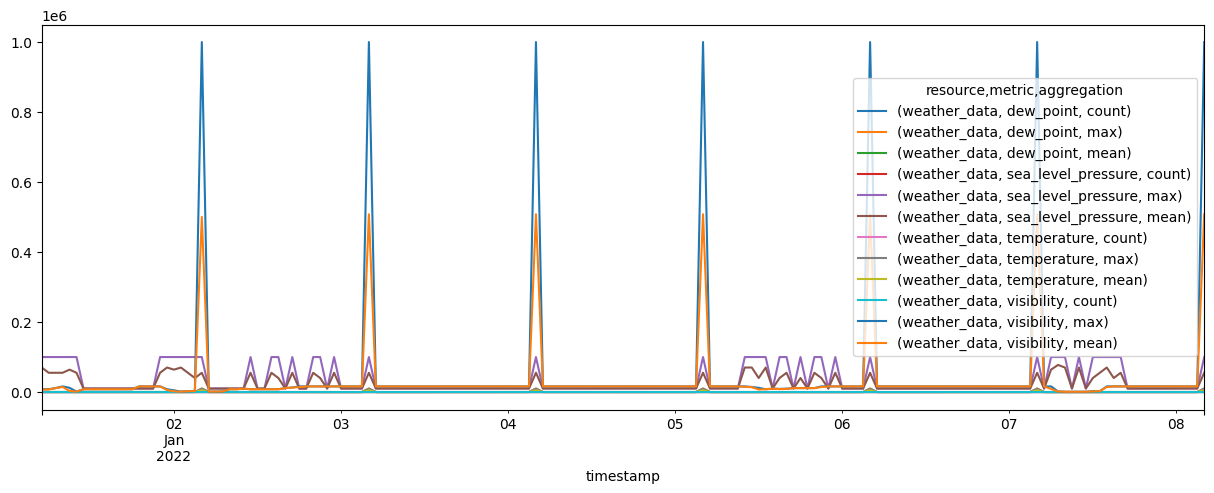

In [13]:
df_now.plot(figsize=(15,5))

You can override parameters of the query definition in a `params` argument.

In [14]:
df_2021_2022 = waylay_client.queries.query.execute(query_name, params={
    'window': 'P1D',
})
df_2021_2022.describe()

resource    weather_data                                               \
metric         dew_point                           sea_level_pressure   
aggregation        count          max         mean              count   
count          24.000000    24.000000    24.000000          24.000000   
mean            2.041667   482.333333   274.445833           2.041667   
std             1.082636  2027.266733  1019.343691           1.082636   
min             1.000000    28.000000    28.000000           1.000000   
25%             1.000000    42.750000    38.375000           1.000000   
50%             2.000000    64.000000    64.000000           2.000000   
75%             3.000000    95.500000    95.500000           3.000000   
max             5.000000  9999.000000  5058.000000           5.000000   

resource                                                                       \
metric                                  temperature                             
aggregation           max          mean       count          max         mean   
count           24.000000     24.000000   24.000000    24.000000    24.000000   
mean         47582.500000  30788.690972    2.041667   428.458333   219.150694   
std          45252.842219  26224.424575    1.082636  2038.524551  1020.567083   
min          10074.000000  10072.000000    1.000000     0.000000     0.000000   
25%          10122.750000  10122.750000    1.000000    10.750000     7.583333   
50%          10205.500000  10205.500000    2.000000    11.000000    11.000000   
75%          99999.000000  55062.875000    3.000000    17.000000    17.000000   
max          99999.000000  77521.250000    5.000000  9999.000000  5010.500000   

resource                                              
metric      visibility                                
aggregation      count            max           mean  
count        24.000000      24.000000      24.000000  
mean          2.041667   52797.666667   31887.608333  
std           1.082636  201866.975531  101644.108923  
min           1.000000     805.000000     802.500000  
25%           1.000000    2414.000000    2279.500000  
50%           2.000000   16093.000000   16046.500000  
75%           3.000000   16093.000000   16093.000000  
max           5.000000  999999.000000  508046.000000

<Axes: xlabel='timestamp'>

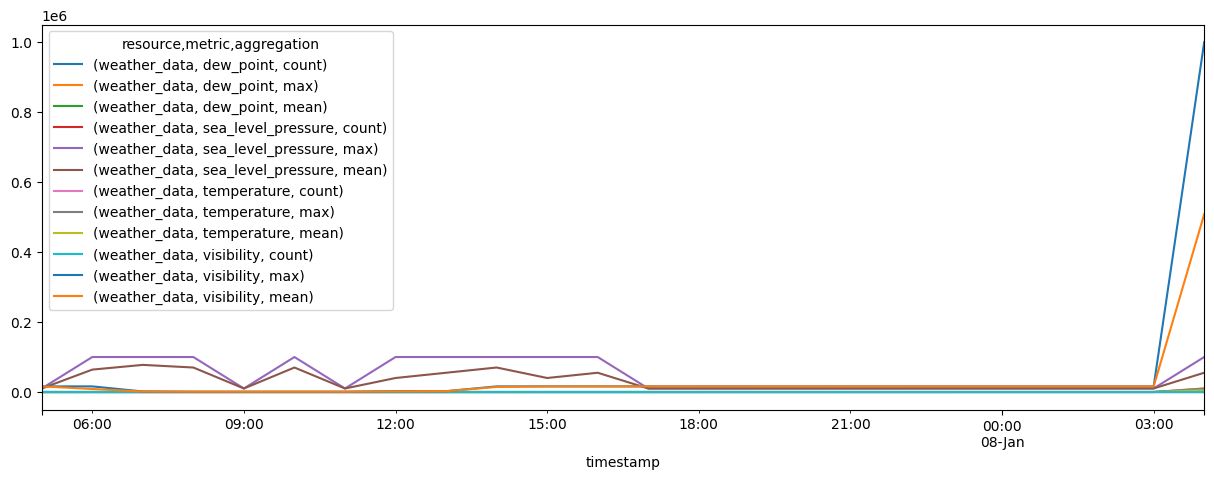

In [15]:
df_2021_2022.plot(figsize=(15,5))

You can suppress the conversion to dataframes by setting `response_constructor=False`.
The full body contains a list of data sets, each having a `data` property containing the data, `columns` containing the series description.

In [16]:
waylay_client.queries.query.execute(
    query_name,
    params={'window':'PT2H'},
    response_constructor=False
)

[{'columns': ['timestamp',
   {'resource': 'weather_data', 'metric': 'dew_point', 'aggregation': 'count'},
   {'resource': 'weather_data', 'metric': 'dew_point', 'aggregation': 'max'},
   {'resource': 'weather_data', 'metric': 'dew_point', 'aggregation': 'mean'},
   {'resource': 'weather_data',
    'metric': 'sea_level_pressure',
    'aggregation': 'count'},
   {'resource': 'weather_data',
    'metric': 'sea_level_pressure',
    'aggregation': 'max'},
   {'resource': 'weather_data',
    'metric': 'sea_level_pressure',
    'aggregation': 'mean'},
   {'resource': 'weather_data',
    'metric': 'temperature',
    'aggregation': 'count'},
   {'resource': 'weather_data', 'metric': 'temperature', 'aggregation': 'max'},
   {'resource': 'weather_data',
    'metric': 'temperature',
    'aggregation': 'mean'},
   {'resource': 'weather_data',
    'metric': 'visibility',
    'aggregation': 'count'},
   {'resource': 'weather_data', 'metric': 'visibility', 'aggregation': 'max'},
   {'resource': 'weat

A stored query can be removed using `queries.query.remove`


In [17]:
waylay_client.queries.query.remove(query_name)

{'messages': [],
 '_links': {'self': {'href': 'http://api.waylay.io/queries/v1/query/all_weather_data',
   'method': 'DELETE'}}}

A query definition does not need to be stored, you can use  `queries.query.execute` with the full query definition as first argument to execute it without saving.

In [18]:
waylay_client.queries.query.execute(query_definition, params={'window':'P5D'})

resource                  weather_data                                     \
metric                       dew_point                 sea_level_pressure   
aggregation                      count     max    mean              count   
timestamp                                                                   
2022-01-03 05:00:00+00:00          1.0    28.0    28.0                1.0   
2022-01-03 06:00:00+00:00          2.0    33.0    30.5                2.0   
2022-01-03 07:00:00+00:00          1.0    44.0    44.0                1.0   
2022-01-03 08:00:00+00:00          1.0    67.0    67.0                1.0   
2022-01-03 09:00:00+00:00          2.0    72.0    69.5                2.0   
...                                ...     ...     ...                ...   
2022-01-08 00:00:00+00:00          2.0   111.0   105.5                2.0   
2022-01-08 01:00:00+00:00          1.0   111.0   111.0                1.0   
2022-01-08 02:00:00+00:00          1.0   111.0   111.0                1.0   
2022-01-08 03:00:00+00:00          2.0   122.0   116.5                2.0   
2022-01-08 04:00:00+00:00          2.0  9999.0  5058.0                2.0   

resource                                                                 \
metric                                      temperature                   
aggregation                    max     mean       count     max    mean   
timestamp                                                                 
2022-01-03 05:00:00+00:00  10168.0  10168.0         1.0    39.0    39.0   
2022-01-03 06:00:00+00:00  10186.0  10177.0         2.0    39.0    36.0   
2022-01-03 07:00:00+00:00  10190.0  10190.0         1.0    28.0    28.0   
2022-01-03 08:00:00+00:00  10181.0  10181.0         1.0    17.0    17.0   
2022-01-03 09:00:00+00:00  10192.0  10186.5         2.0    17.0    14.0   
...                            ...      ...         ...     ...     ...   
2022-01-08 00:00:00+00:00  10192.0  10185.0         2.0    11.0     8.5   
2022-01-08 01:00:00+00:00  10201.0  10201.0         1.0    17.0    17.0   
2022-01-08 02:00:00+00:00  10210.0  10210.0         1.0    17.0    17.0   
2022-01-08 03:00:00+00:00  10219.0  10214.5         2.0    22.0    19.5   
2022-01-08 04:00:00+00:00  99999.0  55113.5         2.0  9999.0  5010.5   

resource                                                  
metric                    visibility                      
aggregation                    count       max      mean  
timestamp                                                 
2022-01-03 05:00:00+00:00        1.0   16093.0   16093.0  
2022-01-03 06:00:00+00:00        2.0   16093.0   16046.5  
2022-01-03 07:00:00+00:00        1.0   16093.0   16093.0  
2022-01-03 08:00:00+00:00        1.0   16093.0   16093.0  
2022-01-03 09:00:00+00:00        2.0   16093.0   16046.5  
...                              ...       ...       ...  
2022-01-08 00:00:00+00:00        2.0   16093.0   16046.5  
2022-01-08 01:00:00+00:00        1.0   16093.0   16093.0  
2022-01-08 02:00:00+00:00        1.0   16093.0   16093.0  
2022-01-08 03:00:00+00:00        2.0   16093.0   16046.5  
2022-01-08 04:00:00+00:00        2.0  999999.0  508046.0  

[120 rows x 12 columns]